# Protein Family Prediction Using Data Mining Techniques

This notebook focuses on classifying proteins into families using machine learning and deep learning approaches. The dataset is derived from UniProtKB/Swiss-Prot and includes three major protein families:
- Kinase
- Transferase
- GPCRs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing All the required Libraries

This section imports all necessary Python libraries and modules for the protein sequence classification project:

## Core Libraries
- `json`: For working with JSON data formats
- `os`: For operating system interactions and file path manipulations
- `pandas` (pd): For data manipulation and analysis with DataFrames
- `numpy` (np): For numerical operations and array processing
- `matplotlib.pyplot` (plt): For basic data visualization
- `seaborn` (sns): For enhanced statistical visualizations
- `random.sample`: For randomly selecting a subset of unique elements

## Data Processing
- `collections.Counter`: For counting hashable objects
- `sklearn.model_selection.train_test_split`: For splitting data into training/test sets
- `sklearn.preprocessing`:
  - `StandardScaler`: For feature standardization
  - `label_binarize`: For converting labels to binary format
  - `LabelEncoder`: For encoding categorical labels

## Machine Learning Models
- `sklearn.ensemble.RandomForestClassifier`: Random Forest classifier
- `sklearn.svm.SVC`: Support Vector Machine classifier
- `xgboost.XGBClassifier`: XGBoost classifier

## Evaluation Metrics
- `sklearn.metrics`:
  - `classification_report`: For text report of main metrics
  - `confusion_matrix`/`ConfusionMatrixDisplay`: For confusion matrix visualization
  - `roc_curve`/`auc`: For ROC curve analysis
  - `roc_auc_score`: For computing Area Under ROC Curve

## Imbalanced Learning
- `imblearn.over_sampling.SMOTE`: For synthetic minority oversampling

## Protein Analysis
- `Bio.SeqUtils.ProtParam.ProteinAnalysis`: For protein sequence analysis
- `SeqIO` : For reading, writing and manipulating biological sequence

## Deep Learning (TensorFlow/Keras)
- `tensorflow.keras.models.Sequential`: For creating neural network models
- `tensorflow.keras.layers`:
  - `LSTM`: Long Short-Term Memory layer
  - `Dense`: Regular densely-connected NN layer
  - `Embedding`: For embedding layers
  - `Bidirectional`: For bidirectional RNNs
  - `Masking`: For masking padded sequences
- `tensorflow.keras.preprocessing`:
  - `pad_sequences`: For sequence padding
  - `Tokenizer`: For text tokenization

In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

## Dataset Paths Configuration

This dictionary defines the file paths for three different protein sequence datasets:
- Kinase
- transferase
- gpcrs

In [ ]:
DATASETS = {
    "kinase": "/content/drive/MyDrive/Colab Notebooks/swissprot_kinase.fasta",
    "transferase": "/content/drive/MyDrive/Colab Notebooks/swissprot_transferase.fasta",
    "gpcrs": "/content/drive/MyDrive/Colab Notebooks/swissprot_gpcrs.fasta"
}

## Amino Acid Sequence Validation and Cleaning

### Valid Amino Acids

- This cell defines the 20 standard amino acids using their single-letter code.

- Checks if all characters in a protein sequence are valid amino acids

- Filters out any non-standard amino acid characters

In [ ]:
VALID_AMINO_ACIDS = set("ACDEFGHIKLMNPQRSTVWY")

def is_valid_sequence(seq):
    return all(aa in VALID_AMINO_ACIDS for aa in seq.upper())

def clean_sequence(seq):
    return ''.join(aa for aa in seq.upper() if aa in VALID_AMINO_ACIDS)

## FASTA Sequence Loader

**Key Features:**
- Biopython's efficient FASTA parsing
- Automatic sequence validation and cleaning
- Minimum length filter (≥10 residues)
- Loading statistics for quality monitoring

In [ ]:
def load_sequences(path):
    """Parses FASTA file, validates and cleans sequences."""
    sequences = []
    try:
        for record in SeqIO.parse(path, "fasta"):
            seq = str(record.seq).upper()
            if is_valid_sequence(seq):
                sequences.append(seq)
            else:
                cleaned = clean_sequence(seq)
                if len(cleaned) >= 10:
                    sequences.append(cleaned)
        print(f"Successfully loaded {len(sequences)} sequences from {path}")
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
    return sequences

## Top k-mer Extraction

Identifies the most frequent k-length subsequences (k-mers) in protein sequences.

Parameters:
- `sequences`: List of protein sequences  
- `k`: Length of subsequences (default=3 for 3-mers/tripeptides)
- `top_n`: Number of top k-mers to return (default=1000)

Process:
1. Counts all possible k-mers across all sequences
2. Returns the `top_n` most frequent k-mers

Feature selection for sequence-based machine learning - common k-mers often represent functionally important motifs.

In [ ]:
def get_top_kmers(sequences, k=3, top_n=1000):
    kmer_counter = Counter()
    for seq in sequences:
        kmers = [seq[i:i+k] for i in range(len(seq)-k+1)]
        kmer_counter.update(kmers)
    top_kmers = [kmer for kmer, _ in kmer_counter.most_common(top_n)]
    return top_kmers

## Protein Feature Extraction

This function computes multiple biologically meaningful features from protein sequences:

### Feature Categories and Rationale

1. Basic Sequence Properties
- `Length`: Fundamental property affecting protein structure/function

2. Amino Acid Composition
- Relative frequency of each standard amino acid (20 features)


3. Biophysical Properties
- `MW`: Molecular weight - affects protein mobility and interactions
- `Aromaticity`: Influences protein stability and binding
- `Instability`: Predicts protein half-life
- `GRAVY`: Hydrophobicity index - important for structure prediction


4. Dipeptide Composition (400 features)
- Relative frequency of all possible amino acid pairs

5. Shannon Entropy
- Measures sequence variability/conservation


### Implementation Notes
- All composition features are normalized by sequence length
- Uses Biopython's `ProteinAnalysis` for reliable biophysical calculations
- Top 3-mers are pre-computed to focus on most informative features
- Includes commented option for aliphatic index (another useful feature)

### Biological Significance
This multi-level feature extraction captures:
- Global sequence characteristics (length, MW)
- Local sequence patterns (di-/tri-peptides)
- Physicochemical properties critical for function
- Information content (entropy)

Such comprehensive feature engineering helps machine learning models identify both obvious and subtle patterns distinguishing protein classes.

In [ ]:
def extract_features(seq, top_3mers):
    """Generates biophysical and k-mer features for a single sequence."""
    features = {}
    L = len()
    features['Length'] = L
    aa_counts = Counter(seq)
    for aa in 'ACDEFGHIKLMNPQRSTVWY':
        features[f'AA_{aa}'] = aa_counts.get(aa, 0) / L
    analyzed = ProteinAnalysis(seq)
    features['MW'] = analyzed.molecular_weight()
    features['Aromaticity'] = analyzed.aromaticity()
    features['Instability'] = analyzed.instability_index()
    features['GRAVY'] = analyzed.gravy()
    dipeptides = [seq[i:i+2] for i in range(L-1)]
    dipep_counts = Counter(dipeptides)
    total_dipep = sum(dipep_counts.values())
    for d1 in 'ACDEFGHIKLMNPQRSTVWY':
        for d2 in 'ACDEFGHIKLMNPQRSTVWY':
            dp = d1 + d2
            features[f'Dipeptide_{dp}'] = dipep_counts.get(dp, 0) / total_dipep if total_dipep else 0

    trimers = [seq[i:i+3] for i in range(L-2)]
    trimer_counts = Counter(trimers)
    total_trimers = sum(trimer_counts.values())
    for kmer in top_3mers:
        features[f'Trimer_{kmer}'] = trimer_counts.get(kmer, 0) / total_trimers if total_trimers else 0

    freqs = np.array([aa_counts.get(aa, 0) / L for aa in 'ACDEFGHIKLMNPQRSTVWY'])
    freqs = freqs[freqs > 0]
    features['Shannon_Entropy'] = -np.sum(freqs * np.log2(freqs))

    return features

## Sequence Processing Pipeline

Data Loading:
- Loads sequences from all datasets (kinase/transferase/GPCRs)
- Combines them into a single list (`all_sequences`)

Feature Extraction:
- Identifies the top 1000 most frequent 3-mers (tripeptides)
- Uses the `get_top_kmers()` function to count all possible 3-length subsequences
- Returns only the most common ones for dimensionality reduction

Creates a unified feature set for downstream machine learning by:
1. Aggregating all protein sequences
2. Selecting the most informative subsequences as features

In [ ]:
all_sequences = []
for label, filepath in DATASETS.items():
    all_sequences.extend(load_sequences(filepath))


top_3mers = get_top_kmers(all_sequences, k=3, top_n=1000)

Successfully loaded 15647 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_kinase.fasta
Successfully loaded 4006 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_transferase.fasta
Successfully loaded 3162 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_gpcrs.fasta


## Data Processing Pipeline

### Workflow Steps:

1. Initialization
   - Creates empty lists `all_data` (features) and `all_labels` (targets)

2. Dataset Processing
   - Iterates through each protein class (kinase/transferase/GPCRs)
   - Loads and validates sequences using `load_sequences()`

3. Class Balancing
   - Special handling for kinase class (typically over-represented):
     - Downsampled to match smallest class size (3,162 sequences)
     - Uses random sampling to maintain balance

4. Feature Extraction
   - Processes each sequence through `extract_features()`
   - Handles extraction errors gracefully with try-catch
   - Appends successful features to `all_data`
   - Tracks corresponding labels in `all_labels`

5. Final Conversion
   - Combines features and labels into a pandas DataFrame
   - Structured format ready for machine learning

### Key Features:
- Class balancing prevents model bias
- Error handling ensures robust processing
- Label preservation maintains data provenance
- DataFrame output enables easy ML integration

### Output Structure:
- Each row represents one protein sequence
- Columns contain extracted features + 'label' column

In [ ]:
all_data = []
all_labels = []
for label, filepath in DATASETS.items():
        if not os.path.exists(filepath): continue

        sequences = load_sequences(filepath)

        if label == 'kinase':
            target_size = min(4006, 3162)
            if len(sequences) > target_size:
                sequences = sample(sequences, target_size)
                print(f"   -> Downsampled {label} to {target_size}")

        for seq in sequences:
            try:
                feats = extract_features(seq, top_3mers)
                if feats:
                    all_data.append(feats)
                    all_labels.append(label)
            except Exception:
                continue

Successfully loaded 15647 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_kinase.fasta
   -> Downsampled kinase to 3162
Successfully loaded 4006 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_transferase.fasta
Successfully loaded 3162 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_gpcrs.fasta


In [ ]:
df = pd.DataFrame(all_data)
df['label'] = all_labels
df.dropna(inplace=True)

print(f"Feature extraction complete. Dataset shape: {df.shape}")

Feature extraction complete. Dataset shape: (0, 1)


## Protein Feature DataFrame

In [ ]:
df

,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,AA_I,AA_K,...,Trimer_FSG,Trimer_LGY,Trimer_KRV,Trimer_DNL,Trimer_PKV,Trimer_VRV,Trimer_TIT,Trimer_IID,Shannon_Entropy,label
0,606,0.070957,0.021452,0.041254,0.074257,0.019802,0.056106,0.021452,0.051155,0.062706,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.164580,kinase
1,230,0.126087,0.008696,0.082609,0.056522,0.043478,0.060870,0.004348,0.065217,0.056522,...,0.0,0.004386,0.000000,0.000000,0.0,0.0,0.000000,0.0,3.957832,kinase
2,194,0.046392,0.025773,0.067010,0.082474,0.061856,0.061856,0.036082,0.061856,0.077320,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.166527,kinase
3,313,0.067093,0.009585,0.051118,0.070288,0.035144,0.060703,0.035144,0.044728,0.086262,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.146971,kinase
4,1383,0.065076,0.031092,0.052784,0.080260,0.032538,0.069414,0.028923,0.044107,0.041938,...,0.0,0.000724,0.000724,0.000000,0.0,0.0,0.000724,0.0,4.117805,kinase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10325,312,0.054487,0.032051,0.028846,0.012821,0.060897,0.044872,0.028846,0.057692,0.025641,...,0.0,0.000000,0.000000,0.003226,0.0,0.0,0.000000,0.0,4.053849,gpcrs
10326,309,0.061489,0.025890,0.029126,0.016181,0.064725,0.051780,0.025890,0.084142,0.032362,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.082661,gpcrs
10327,314,0.057325,0.038217,0.038217,0.009554,0.063694,0.038217,0.025478,0.070064,0.028662,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.024573,gpcrs
10328,10,0.000000,0.000000,0.000000,0.300000,0.000000,0.100000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.446439,gpcrs


In [ ]:
df.isnull().values.any()

np.False_

## Dataset Finalization

### Processing Steps:

1. DataFrame Creation  
2. Data Cleaning
3. Quality Check

In [ ]:
df = pd.DataFrame(all_data)
df['label'] = all_labels
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


print(f"Final dataset shape: {df.shape}")
print("Class distribution:")
print(df['label'].value_counts())

Final dataset shape: (10330, 1427)
Class distribution:
label
transferase    4006
kinase         3162
gpcrs          3162
Name: count, dtype: int64


## Class Distribution Visualization (Pre-Balancing)

Visualizes the raw distribution of protein classes before any balancing techniques are applied.

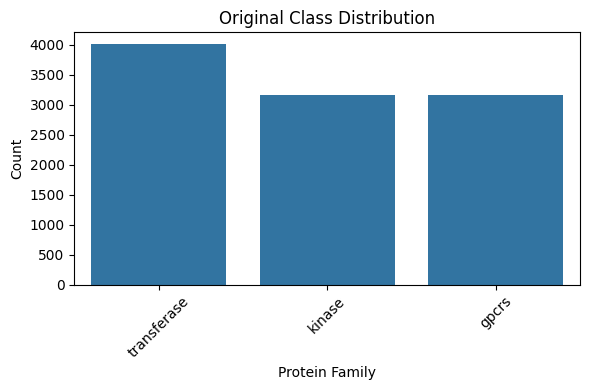

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Original Class Distribution")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preprocessing for Protein Classification

Splits features and labels, standardizes the data, and balances class distribution using SMOTE

In [ ]:
X = df.drop('label', axis=1)
y = df['label']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)
print(f"Data balanced using SMOTE. New X shape: {X_resampled.shape}")

Data balanced using SMOTE. New X shape: (12018, 1426)


## Post-SMOTE Class Distribution Visualization
  
Visual confirmation of successful class balancing after applying SMOTE oversampling.


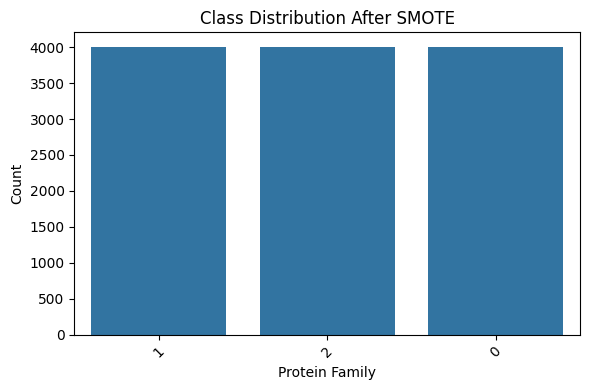

In [ ]:
resampled_df = pd.DataFrame({'label': y_resampled})
plt.figure(figsize=(6, 4))
sns.countplot(data=resampled_df, x='label', order=resampled_df['label'].value_counts().index)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Protein Family")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preparation for Model Training

### Label Processing
- **Label Encoding**: Converts text labels ('kinase', 'transferase', 'gpcrs') to numerical values (0, 1, 2) using `LabelEncoder`
- **Binarization**: Creates one-hot encoded versions of labels for ROC curve analysis with `label_binarize`

### Dataset Splitting
- `80% training / 20% testing split`


In [ ]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
classes = le.classes_
y_test_bin = label_binarize(y_test, classes=range(len(classes)))

## Model Definitions for Protein Classification

- `Random Forest`: Bagging-based, robust to noise (good for biological data variability)

- `SVM`: Kernel-based, excels in high-dimensional spaces (ideal for 1,000+ features)

- `XGBoost`: Boosting-based, handles class imbalance (optimized for SMOTE-adjusted data)


In [ ]:
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf']
    }
}

In [ ]:

base_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [ ]:
best_models = {}
cv_results = {}

for name, model in base_models.items():
    print(f" Tuning {name}...")

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=5,
        scoring='accuracy',
        cv=cv,
        n_jobs=1,
        verbose=0,
        random_state=42
    )

    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_
    cv_results[name] = search.best_score_

    print(f" Best Params: {search.best_params_}")
    print(f" Best CV Accuracy: {search.best_score_:.4f}\n")
print(f"Collection Complete. Models in memory: {list(best_models.keys())}")

 Tuning Random Forest...
 Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'class_weight': None}
 Best CV Accuracy: 0.9750

 Tuning XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:09:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:17:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:25:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:34:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:35:54] WARNING: /w

 Best Params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
 Best CV Accuracy: 0.9817

 Tuning SVM...
 Best Params: {'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
 Best CV Accuracy: 0.9829

Collection Complete. Models in memory: ['Random Forest', 'XGBoost', 'SVM']


### Visual of Optimized Model

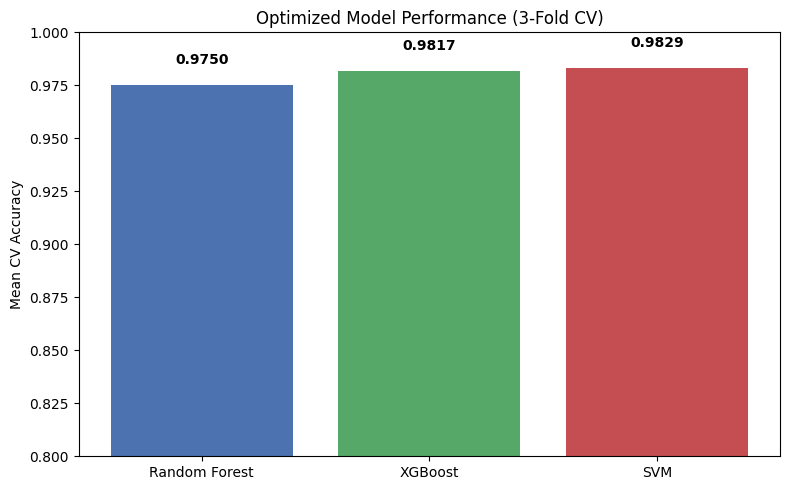

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(cv_results.keys(), cv_results.values(), color=['#4c72b0', '#55a868', '#c44e52'])
plt.ylabel('Mean CV Accuracy')
plt.title('Optimized Model Performance (3-Fold CV)')
plt.ylim(0.8, 1.0)
for i, v in enumerate(cv_results.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## Model Training and Evaluation

Trains and evaluates multiple machine learning models to classify protein families, comparing their performance.

In [ ]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name} | Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


Model: Random Forest | Test Accuracy: 0.9829
              precision    recall  f1-score   support

       gpcrs       1.00      0.99      0.99       801
      kinase       0.95      1.00      0.98       801
 transferase       1.00      0.96      0.98       802

    accuracy                           0.98      2404
   macro avg       0.98      0.98      0.98      2404
weighted avg       0.98      0.98      0.98      2404


Model: XGBoost | Test Accuracy: 0.9871
              precision    recall  f1-score   support

       gpcrs       0.99      1.00      0.99       801
      kinase       0.98      0.99      0.98       801
 transferase       0.99      0.98      0.98       802

    accuracy                           0.99      2404
   macro avg       0.99      0.99      0.99      2404
weighted avg       0.99      0.99      0.99      2404


Model: SVM | Test Accuracy: 0.9896
              precision    recall  f1-score   support

       gpcrs       1.00      0.99      1.00       801
      k

## Confusion Matrix Visualization

Generates and displays confusion matrices for each trained model to evaluate classification performance visually.

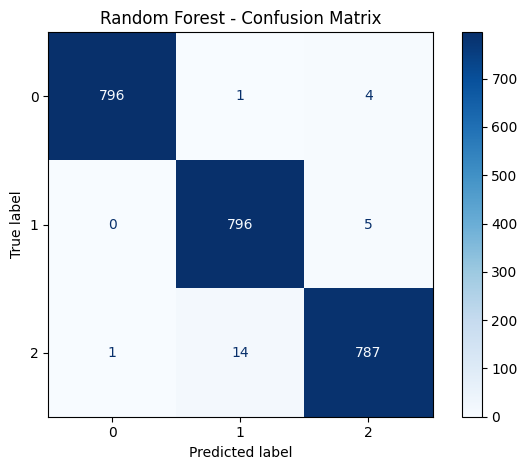

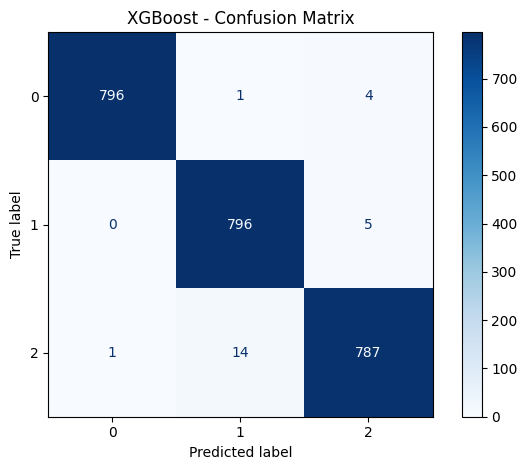

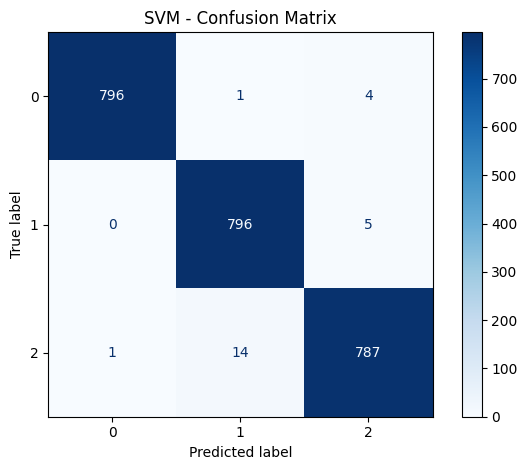

In [ ]:
for name, model in best_models.items():
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

## ROC Curve Analysis

Evaluates model performance using Receiver Operating Characteristic (ROC) curves for each protein class, providing a visual assessment of classification quality across all decision thresholds.

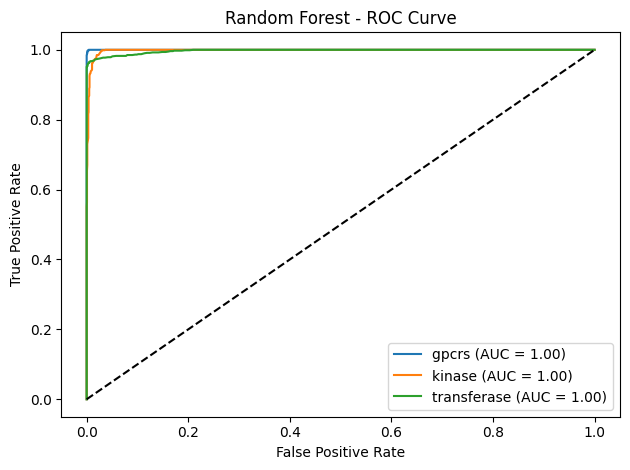

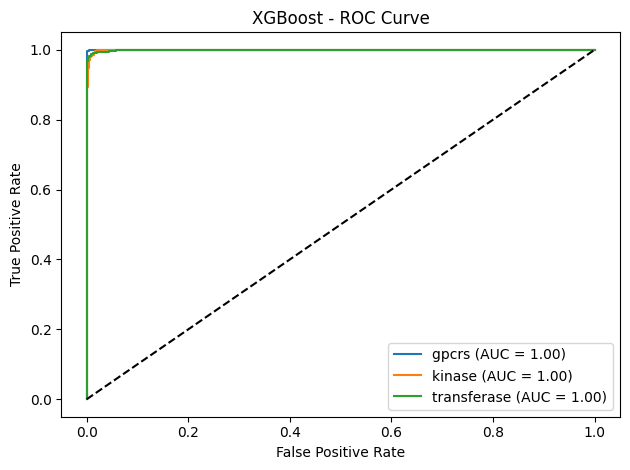

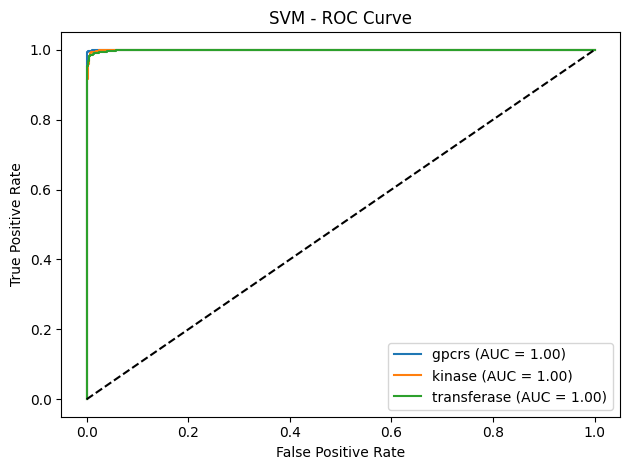

In [ ]:
for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = zip(*[roc_curve(y_test_bin[:, i], y_score[:, i]) for i in range(len(classes))])
        roc_auc = [auc(fpr[i], tpr[i]) for i in range(len(classes))]
        plt.figure()
        for i in range(len(classes)):
            plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"{name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

## Feature Importance Analysis

Identifies and visualizes the most influential features for models that support importance scoring.

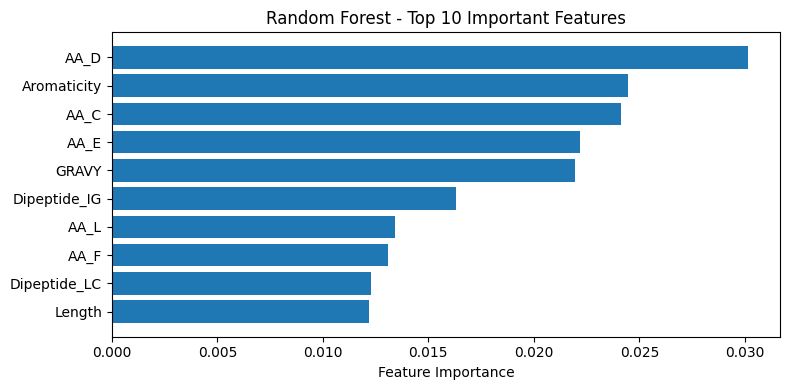

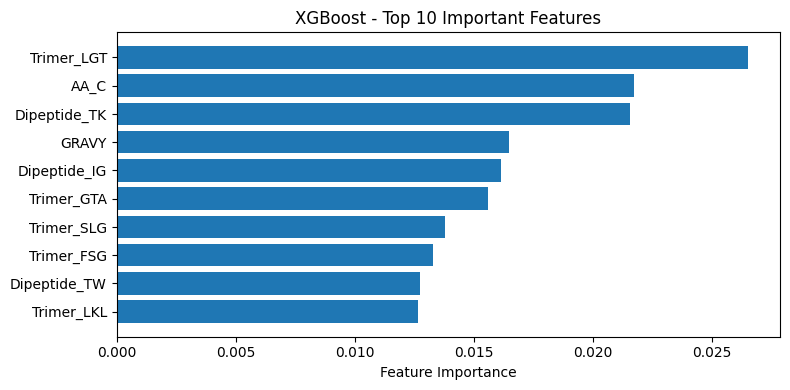

In [ ]:
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[-10:]
        plt.figure(figsize=(8, 4))
        plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"{name} - Top 10 Important Features")
        plt.tight_layout()
        plt.show()

## Misclassification Analysis

Examines model errors by showing:
- True vs predicted labels
- Prediction confidence scores
- First 5 misclassified examples per model

In [ ]:
for name, model in best_models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)
        misclassified_idx = np.where(y_pred != y_test)[0]
        print(f"\n{name} Misclassified Samples:")
        for i in misclassified_idx[:5]:
            print(f"True: {y_test[i]}, Predicted: {y_pred[i]}, Confidence: {np.max(y_prob[i]):.2f}")


Random Forest Misclassified Samples:
True: 2, Predicted: 1, Confidence: 0.69
True: 2, Predicted: 1, Confidence: 0.62
True: 1, Predicted: 2, Confidence: 0.44
True: 2, Predicted: 1, Confidence: 0.47
True: 0, Predicted: 2, Confidence: 0.64

XGBoost Misclassified Samples:
True: 2, Predicted: 1, Confidence: 0.75
True: 2, Predicted: 1, Confidence: 0.62
True: 1, Predicted: 2, Confidence: 0.59
True: 2, Predicted: 1, Confidence: 0.51
True: 0, Predicted: 2, Confidence: 1.00

SVM Misclassified Samples:
True: 2, Predicted: 1, Confidence: 0.97
True: 2, Predicted: 1, Confidence: 0.58
True: 1, Predicted: 2, Confidence: 0.67
True: 2, Predicted: 1, Confidence: 0.58
True: 0, Predicted: 2, Confidence: 0.82


## Deep Learning (BRNN) Data Preparation

This pipeline preprocesses protein sequences for deep learning by tokenizing amino acids, padding to 512 residues, and one-hot encoding labels, then splits the data into train/test sets. The output provides formatted inputs for a bidirectional RNN while preserving biological sequence information.

In [ ]:
seqs = []
labels = []
for label, filepath in DATASETS.items():
    sequences = load_sequences(filepath)
    for seq in sequences:
        if is_valid_sequence(seq):
            seqs.append(seq)
            labels.append(label)

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
seq_encoded = tokenizer.texts_to_sequences(seqs)
seq_padded = pad_sequences(seq_encoded, maxlen=512, padding='post')

le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_onehot = pd.get_dummies(y_encoded).values

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(seq_padded, y_onehot, test_size=0.2, random_state=42)

Successfully loaded 15647 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_kinase.fasta
Successfully loaded 4006 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_transferase.fasta
Successfully loaded 3162 sequences from /content/drive/MyDrive/Colab Notebooks/swissprot_gpcrs.fasta


# BRNN Architecture

**Structure**:
1. **Embedding Layer**: Maps amino acid tokens to 16D vectors (`input_dim=vocab_size`)
2. **Masking Layer**: Ignores padding values (0.0) in sequences
3. **Bidirectional LSTM**: 64-unit LSTM processing sequences in both directions (→ and ←)
4. **Dense Layers**:
   - 32-unit ReLU hidden layer
   - Softmax output layer (`units=num_classes`)

**Configuration**:
- Optimizer: Adam (adaptive learning rate)
- Loss: Categorical crossentropy (multi-class)
- Metric: Accuracy, Precision, Recall

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Masking, Dropout
brnn = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=16, input_length=512),
    Masking(mask_value=0.0),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_onehot.shape[1], activation='softmax')
])

brnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])
brnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_1 (Masking)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## BRNN Model Training & Evaluation

**Training Process**:
- Trained for 10 epochs with batch size of 64
- Uses 20% of training data for validation
- Tracks both training and validation accuracy

**Visualization**:
- Line plot comparing training vs validation accuracy



Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.6696 - loss: 0.8547 - precision: 0.6642 - recall: 0.5161 - val_accuracy: 0.7264 - val_loss: 0.6717 - val_precision: 0.7577 - val_recall: 0.6773
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7529 - loss: 0.6125 - precision: 0.7679 - recall: 0.7282 - val_accuracy: 0.7979 - val_loss: 0.4639 - val_precision: 0.7991 - val_recall: 0.7962
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7835 - loss: 0.5171 - precision: 0.7912 - recall: 0.7724 - val_accuracy: 0.8055 - val_loss: 0.4400 - val_precision: 0.8066 - val_recall: 0.8031
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8063 - loss: 0.4435 - precision: 0.8073 - recall: 0.8051 - val_accuracy: 0.8329 - val_loss: 0.3732 - val_precision: 0.8352 - val_recall: 0.8299
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8359 - loss: 0.3800 - precision: 0.8372 - recall: 0.8318 - val_accuracy: 0.8647 - val_l

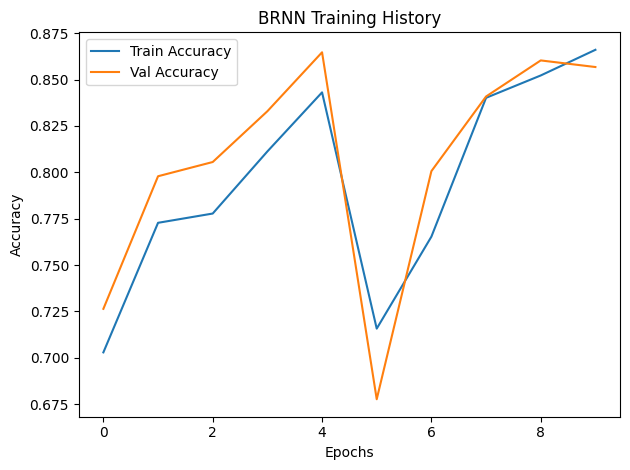

In [ ]:
history = brnn.fit(X_train_seq, y_train_seq, epochs=10, batch_size=64, validation_split=0.2)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('BRNN Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## BRNN Model Evaluation

**Test Performance Metrics**:
- **Loss**: `{eval_score[0]:.4f}` (Cross-entropy error - lower is better)
- **Accuracy**: `{eval_score[1]:.4f}` (Overall correct predictions)
- **Precision**: `{eval_score[2]:.4f}` (True positives / predicted positives)
- **Recall**: `{eval_score[3]:.4f}` (True positives / actual positives)

In [ ]:
eval_score = brnn.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nBRNN Evaluation Metrics:")
print(f"Test Loss: {eval_score[0]:.4f}")
print(f"Test Accuracy: {eval_score[1]:.4f}")
print(f"Test Precision: {eval_score[2]:.4f}")
print(f"Test Recall: {eval_score[3]:.4f}")


BRNN Evaluation Metrics:
Test Loss: 0.3284
Test Accuracy: 0.8657
Test Precision: 0.8751
Test Recall: 0.8586


## Multiclass F1 Score Calculation

In [ ]:
y_pred = brnn.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_seq, axis=1)

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


## Multiclass Classification Report

Provides detailed performance metrics for each protein family class and overall model performance.

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       gpcrs       0.84      0.96      0.89       626
      kinase       0.89      0.92      0.91      3120
 transferase       0.77      0.58      0.66       817

    accuracy                           0.87      4563
   macro avg       0.83      0.82      0.82      4563
weighted avg       0.86      0.87      0.86      4563



## BRNN Confusion Matrix Visualization

Visualizes model prediction patterns across protein family classes using a heatmap-style matrix.

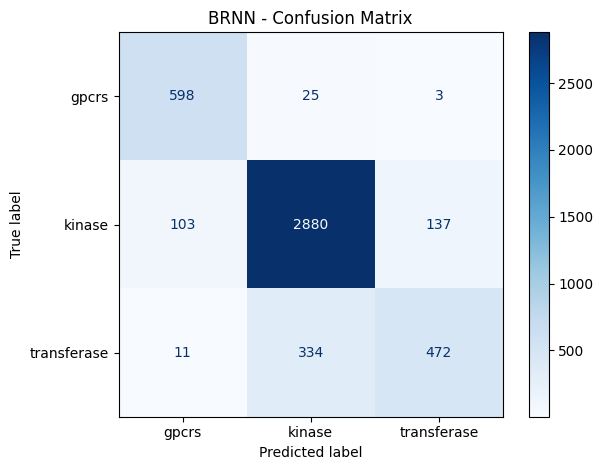

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('BRNN - Confusion Matrix')
plt.tight_layout()
plt.show()

# BRNN Summary

After training the model

In [ ]:
brnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 512, 16)        │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_1 (Masking)             │ (None, 512, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,107 (539.48 KB)

 Trainable params: 46,035 (179.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,072 (359.66 KB)

## Model Performance Comparison

Directly compares classification effectiveness of different algorithms on the protein family prediction task using a standardized metric (accuracy).

In [ ]:
if 'model_scores' not in locals():
    model_scores = {}

if 'best_models' in locals() and 'X_test' in locals() and 'y_test' in locals():
    print("Recovering scores for tuned models...")
    for name, model in best_models.items():
        try:
            y_pred = model.predict(X_test)
            model_scores[name] = accuracy_score(y_test, y_pred)
        except Exception as e:
            print(f"Could not evaluate {name}: {e}")

if 'eval_score' in locals():
    model_scores['BRNN'] = eval_score[1]
    print(f"Added BRNN score: {eval_score[1]:.4f}")
else:
    print("Error: 'eval_score' not found. Please run the BRNN model evaluation cell first.")


print("\nFinal Model Scores:")
print(model_scores)

Recovering scores for tuned models...
Added BRNN score: 0.8657

Final Model Scores:
{'BRNN': 0.8656585812568665, 'Random Forest': 0.9829450915141431, 'XGBoost': 0.9871048252911814, 'SVM': 0.9896006655574043}


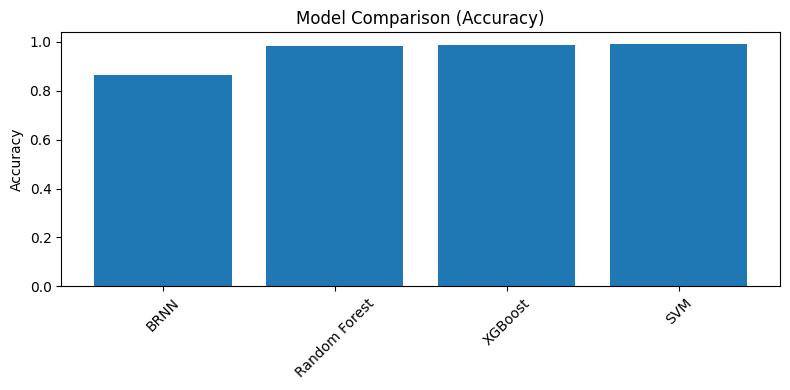

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(model_scores.keys(), model_scores.values())
plt.ylabel('Accuracy')
plt.title('Model Comparison (Accuracy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Selection Analysis

Identifies the most discriminative features for protein classification from the original 1,000+ features.


In [ ]:
rfe_model = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=20)
rfe_model.fit(X_scaled, y)
selected_features_rfe = X.columns[rfe_model.support_]
print("Top 20 features selected by RFE:")
print(selected_features_rfe)

mi = mutual_info_classif(X_scaled, y, discrete_features=False)
mi_series = pd.Series(mi, index=X.columns)
print("Top 20 features by Mutual Information:")
print(mi_series.sort_values(ascending=False).head(20))

Top 20 features selected by RFE:
Index(['AA_C', 'AA_D', 'AA_E', 'AA_K', 'AA_S', 'Aromaticity', 'GRAVY',
       'Dipeptide_EE', 'Dipeptide_EL', 'Dipeptide_IG', 'Dipeptide_LL',
       'Dipeptide_RL', 'Dipeptide_SS', 'Dipeptide_TV', 'Dipeptide_TW',
       'Dipeptide_VG', 'Trimer_DFG', 'Trimer_IGE', 'Trimer_KEA', 'Trimer_GKP'],
      dtype='object')
Top 20 features by Mutual Information:
AA_C            0.525862
AA_D            0.517488
Aromaticity     0.495600
AA_F            0.492748
AA_E            0.488266
GRAVY           0.459164
Dipeptide_FL    0.401839
MW              0.398443
Dipeptide_LL    0.393568
AA_W            0.392588
Length          0.382983
AA_G            0.378418
AA_L            0.374790
Dipeptide_IG    0.362077
AA_S            0.350094
Dipeptide_LF    0.346686
Dipeptide_IL    0.331178
Dipeptide_LV    0.330068
AA_K            0.325499
AA_Y            0.324490
dtype: float64


## Protein Sequence Clustering Analysis

Identifies potential subclasses or shared characteristics that supervised models may have missed.

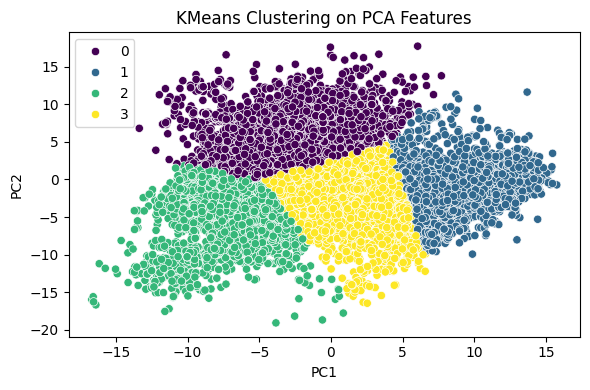

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('KMeans Clustering on PCA Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

## Nonlinear Protein Sequence Clustering (t-SNE + DBSCAN)

**Pipeline**:
1. **t-SNE Dimensionality Reduction** (`perplexity=30`):
   - Captures nonlinear structure in high-dim feature space
   - Projects to 2D while preserving local neighborhoods

2. **DBSCAN Clustering** (`eps=2.0`, `min_samples=5`):
   - Identifies density-based clusters
   - Automatically detects outliers (noise points)

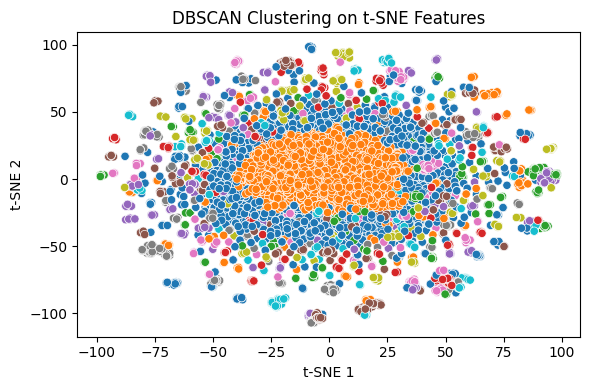

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
db = DBSCAN(eps=2.0, min_samples=5).fit(X_tsne)
labels_db = db.labels_

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_db, palette='tab10')
plt.title('DBSCAN Clustering on t-SNE Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend().remove()
plt.tight_layout()
plt.show()